<h1>Trending Youtube Videos</h1>
<br/>
<p>In this Report a dataset containing some exploratory data analysis is performed on some youtube videos. The intention is to find any relationships which could have an intuitative explanation.</p>

In [92]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import re

<p>Let's have a look at the GB dataset to begin start. source - https://www.kaggle.com/datasnaek/youtube-new</p>

In [93]:
gb_df = pd.read_csv('GBvideos.csv')
gb_df.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...


<p>Now lets create a dataframe which contains all datasets including catagory names.</p>
<p>Let's also add a few new metrics which could yield some interesting information around viewership.</p>


- "Number of Interactions": Likes + Dislikes + Comments
- "Like To Dislike Ratio": Likes / (Likes + Dislikes)
- "Views To Interactions Ratio":  Likes + Dislikes + Comments / Views

In [94]:
def CatJsonToDF(path):
    df = pd.read_json(path)
    df["category_id"] = df["items"].apply(lambda x: x["id"])
    df["Catagory Names"] = df["items"].apply(lambda x: x["snippet"]["title"])
    df["category_id"] = pd.to_numeric(df["category_id"])
    df = df.drop(["kind", "etag", "items"], axis=1)
    return df

allCats = CatJsonToDF('CA_category_id.json')

pd.concat([allCats, CatJsonToDF('DE_category_id.json')])
pd.concat([allCats, CatJsonToDF('FR_category_id.json')])
pd.concat([allCats, CatJsonToDF('GB_category_id.json')])
pd.concat([allCats, CatJsonToDF('IN_category_id.json')])
pd.concat([allCats, CatJsonToDF('JP_category_id.json')])
pd.concat([allCats, CatJsonToDF('KR_category_id.json')])
pd.concat([allCats, CatJsonToDF('MX_category_id.json')])
pd.concat([allCats, CatJsonToDF('RU_category_id.json')])
pd.concat([allCats, CatJsonToDF('US_category_id.json')])


CA = pd.read_csv('CAvideos.csv')
DE = pd.read_csv('DEvideos.csv')
FR = pd.read_csv('FRvideos.csv')
GB = pd.read_csv('GBvideos.csv')
IN = pd.read_csv('INvideos.csv')
JP = pd.read_csv('JPvideos.csv', encoding='latin')
MX = pd.read_csv('MXvideos.csv', encoding='latin')
RU = pd.read_csv('RUvideos.csv', encoding='latin')
KR = pd.read_csv('KRvideos.csv', encoding='latin')
US = pd.read_csv('USvideos.csv')

CA['country']='Canada'
DE['country']='Germany'
FR['country']='France'
GB['country']='Great Britain'
IN['country']='India'
JP['country']='Japan'
KR['country']='South Korea'
MX['country']='Mexico'
RU['country']='Russia'
US['country']='United States'


allVideos = CA

allVideos = pd.concat([allVideos, DE] )
allVideos = pd.concat([allVideos, FR] )
allVideos = pd.concat([allVideos, GB] )
allVideos = pd.concat([allVideos, IN] )
allVideos = pd.concat([allVideos, JP] )
allVideos = pd.concat([allVideos, MX] )
allVideos = pd.concat([allVideos, RU] )
allVideos = pd.concat([allVideos, US] )


AllData = pd.merge(allVideos, allCats, how="inner", on="category_id")

#convert object type to strings - this is necessary for regex later.
AllData["description"] = AllData["description"].astype(str) 

AllData["Number of Interactions"] = AllData["dislikes"] + AllData["likes"] + AllData["comment_count"]
AllData["Like To Dislike Ratio"] = AllData["likes"] / (AllData["dislikes"] + AllData["likes"])
AllData["Views To Interactions Ratio"] =  AllData["Number of Interactions"] / AllData["views"] 

AllData.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,Catagory Names,Number of Interactions,Like To Dislike Ratio,Views To Interactions Ratio
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Canada,Music,956727,0.947740,0.055758
1,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,Canada,Music,1740279,0.987263,0.051912
2,H1KBHFXm2Bg,17.14.11,21 Savage - Bank Account (Official Music Video),21 Savage,10,2017-11-10T19:00:02.000Z,"21 savage|""bank account""|""21 savage bank accou...",5068229,263596,8585,...,https://i.ytimg.com/vi/H1KBHFXm2Bg/default.jpg,False,False,False,Watch the official music video of Bank Account...,Canada,Music,301157,0.968458,0.059421


<p>Lets map out some correlations to see if there are any relationships which are worth a further investigation</p>

<AxesSubplot:>

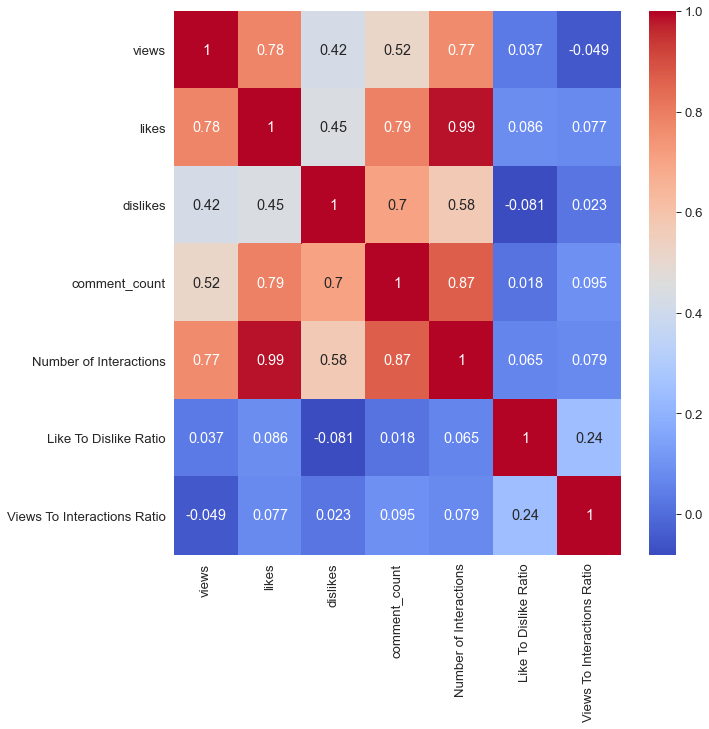

In [95]:
sns.set_context("paper", font_scale=1.5) #Lets set this up for all seaborn figures at a later point.                                                  

fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(AllData[["views", "likes", "dislikes", "comment_count", "Number of Interactions", "Like To Dislike Ratio", "Views To Interactions Ratio"]].corr(), cmap="coolwarm", annot=True)

<b>Fig 1. </b><p>Looking at the above correlation heatmap, it is unsurprising that we find some strong positive corellations between the factors which are understood as markers of a high quality video with a large audience, i.e. the number of views, likes, number of comments and number of interactions.. 

The weaker positive correlations between the number of dislikes and qualities of a good video can be explained intuitively, i.e. a weak positive corellation between dislikes and views is a result which could be a caused by higher numbers of dislikes putting people off from viewing the video, however of course on the flip side it is important to note that there will still be a positive corellation since people need to view the video in order to leave a dislike. 

There are not any particularly note-worthy corellations attained from the like to dislike ratio or view to interaction ratio which can provide much further insight. 


Lets examine a couple of relationships in greater detail, starting with views vs likes, dislikes and number of comments
</p>


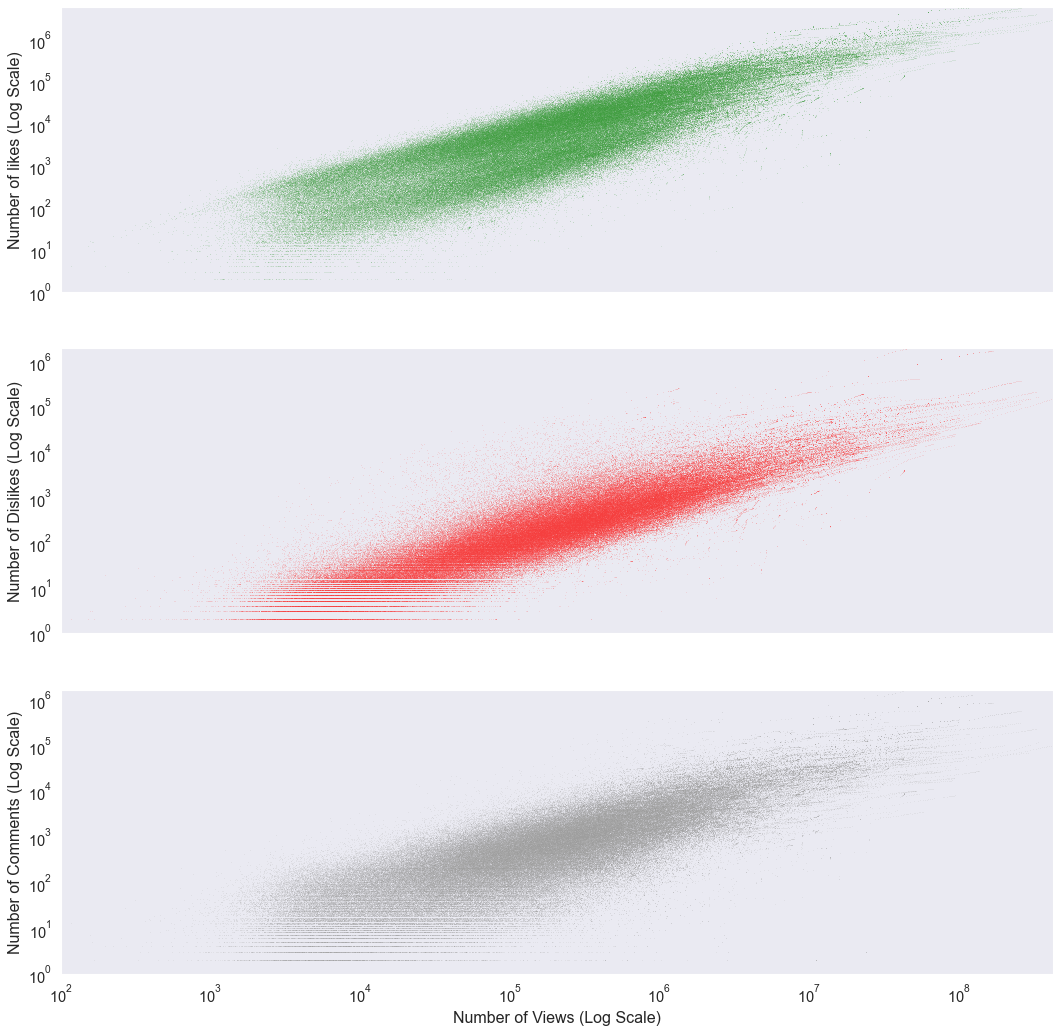

In [96]:
yAxes = ["likes", "dislikes", "comment_count"]
yLabels = ["Number of likes (Log Scale)", "Number of Dislikes (Log Scale)", "Number of Comments (Log Scale)"]
markerColors = ['green', 'red', 'grey']
fig,axes = plt.subplots(3,1, figsize=(16,16), sharex=True, dpi=80)
maxViews = AllData["views"].max()
i = 0
for ax in axes:
    maxY = AllData[yAxes[i]].max()
    ax = sns.scatterplot(ax=ax, x='views',y=yAxes[i],data=AllData, s=0.1, color=markerColors[i])
    ax.set(xlabel="Number of Views (Log Scale)", ylabel=yLabels[i], xscale="log", yscale="log", ylim=(1,maxY), xlim=(100,maxViews))
    i = i + 1


<b>Fig 2. </b><p>Unsurprisingly it is clear that as the number of views increases, the number of comments,views and dislikes also increases. Now lets see if we can deduce any structure from the catagorical data -  note that the stratification we see along the y-axis in the above figures is caused by the the fact we are looking at discreet low-number quantities</p>

<AxesSubplot:xlabel='count', ylabel='Catagory Names'>

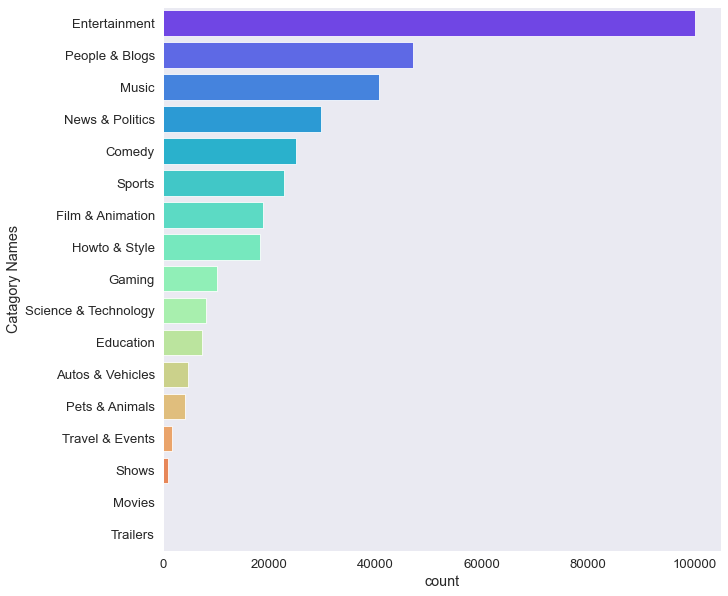

In [97]:
fig, ax = plt.subplots(figsize=(10,10))   

sns.countplot(y="Catagory Names", data=AllData, palette='rainbow', order = AllData['Catagory Names'].value_counts().index)


<b>Fig 3. </b><p>Just considering the top 5 most popular catagories to reduce noise, to make the comparison more useful in terms of understanding the distributions, lets take random samples with from each of these catagories so each distibution has the same overall volumne. We can then look at the distribution of viewership metrics of each of these catagories</p>

In [98]:
#Lets drop the Movies and Trailer data - there is too little data
AllData = AllData[~AllData["Catagory Names"].isin(['Movies', 'Trailers'])]

[Text(0, 1, '1'),
 Text(0, 2, '10'),
 Text(0, 3, '100'),
 Text(0, 4, '1,000'),
 Text(0, 5, '10,000'),
 Text(0, 6, '100,000'),
 Text(0, 7, '1,000,000'),
 Text(0, 8, '10,000,000')]

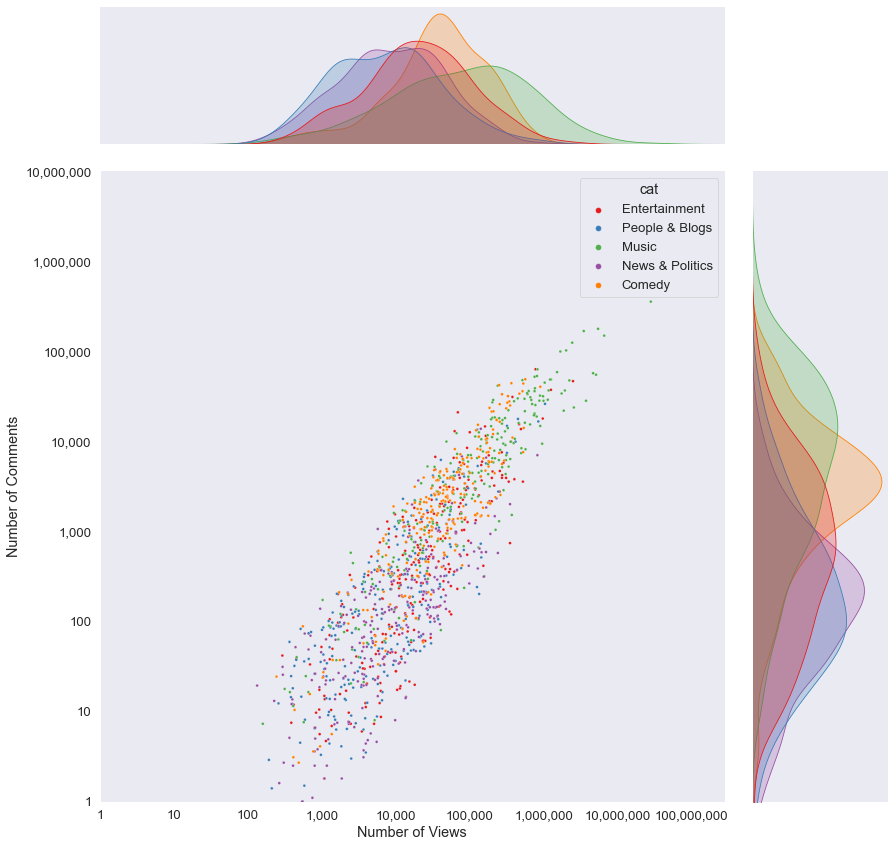

In [99]:
top5Cats = AllData["Catagory Names"].value_counts()[:5].index.tolist()
AllData = AllData[AllData["likes"] > 0] 

allSamples = pd.DataFrame()
i= 0
for cat in top5Cats:
    sample = AllData[(AllData["Catagory Names"] == cat)].sample(n=250, random_state=1)
    temp = pd.DataFrame()
    temp["views"] = sample["views"]
    temp["logViews"] = np.log10(temp["views"])    
    temp["likes"] = sample["likes"]
    temp["logLikes"] = np.log10(temp["likes"])    
    temp["dislikes"] = sample["dislikes"]
    temp["comment_count"] = sample["comment_count"]
    temp["cat"] = sample["Catagory Names"]
    allSamples = allSamples.append(temp)


ax = sns.jointplot(x='logViews',y='logLikes',data=allSamples, s=8, hue="cat", kind="scatter", height=12, ratio = 4, palette="Set1")
ax.ax_joint.set_ylim(1,allSamples["logLikes"].max() + 1)
ax.ax_joint.set_xlim(1,allSamples["logViews"].max() + 1)

ax.ax_joint.set_ylabel('Number of Comments')
ax.ax_joint.set_xlabel('Number of Views')
ax.ax_joint.set_xticks([1,2,3,4,5,6,7,8,9])
ax.ax_joint.set_xticklabels(['1','10','100','1,000','10,000','100,000','1,000,000','10,000,000','100,000,000'])
ax.ax_joint.set_yticks([1,2,3,4,5,6,7,8])
ax.ax_joint.set_yticklabels(['1','10','100','1,000','10,000','100,000','1,000,000','10,000,000'])


<b>Fig 4. </b><p>As we can see the most viewed and most commented videos are dominated by the musical catagory, closely followed by entertainment, however we are only looking at the top 5 catagories by population size in the initial dataset, let's examine the viewership metrics of all catagories now.</p>

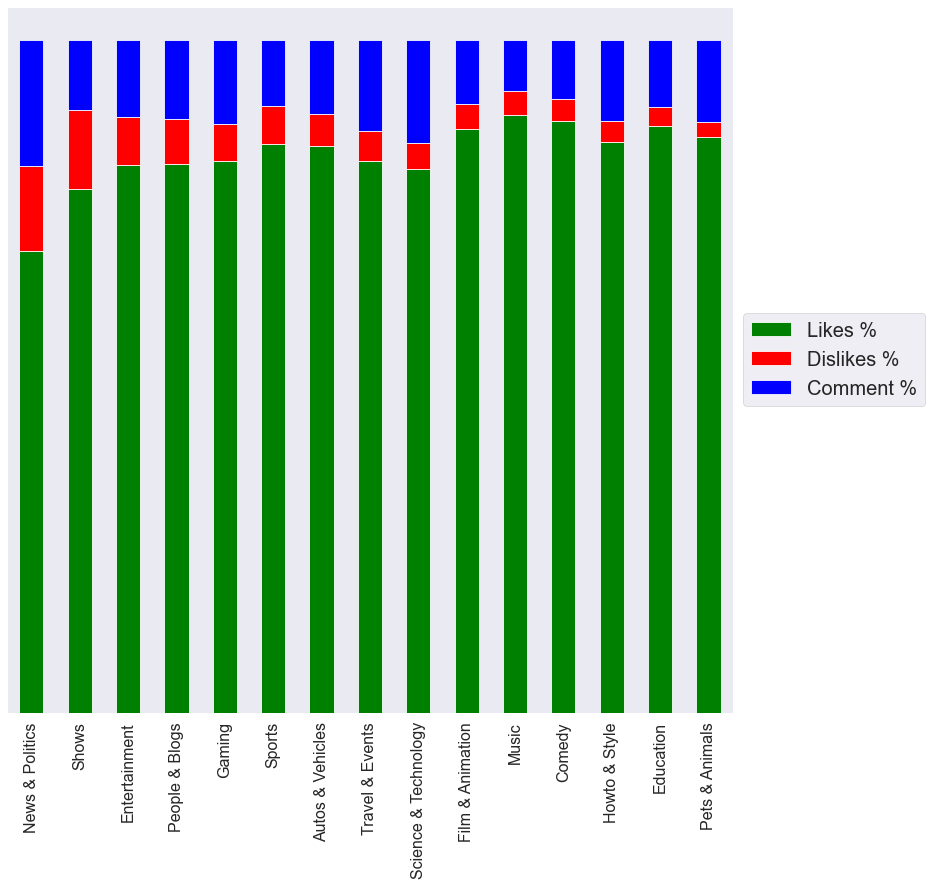

In [100]:
AllDataGrpDF =  AllData.groupby(['Catagory Names']).mean()
AllDataGrpDF['Likes %'] = AllDataGrpDF['likes']/AllDataGrpDF['Number of Interactions']
AllDataGrpDF['Dislikes %'] = AllDataGrpDF['dislikes']/AllDataGrpDF['Number of Interactions']
AllDataGrpDF['Comment %'] = AllDataGrpDF['comment_count']/AllDataGrpDF['Number of Interactions']
AllDataGrpDF['likeDislikeRatioAv'] = AllDataGrpDF['Likes %']/AllDataGrpDF['Dislikes %']

AllDataGrpDF.sort_values(by=['likeDislikeRatioAv'], inplace=True, ascending=True)

fig, ax = plt.subplots(figsize=(10,10))   

c = ['g','r', 'b']

AllDataGrpDF
ax = AllDataGrpDF[['Likes %', 'Dislikes %', 'Comment %']].plot(kind="bar", color=c, stacked=True, figsize=(13,13), fontsize =16, xlabel='', ax=ax)

ax.axes.yaxis.set_ticks([])
fig.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

<b>Fig 5. </b><p>This plot shows the relative likes, dislikes and comments of different catagories, ordered by the ratio of Likes/Dislikes. We can see that whilst News and Politics gains the most dislikes per like, pets and animals gains the fewest. This could be intuitively explained as News and Politics is far more a divisive topic, and is more likely to cause people to react negatively than Pet Videos. Lets investigate a couple more interesting trends between viewership stats. </p>

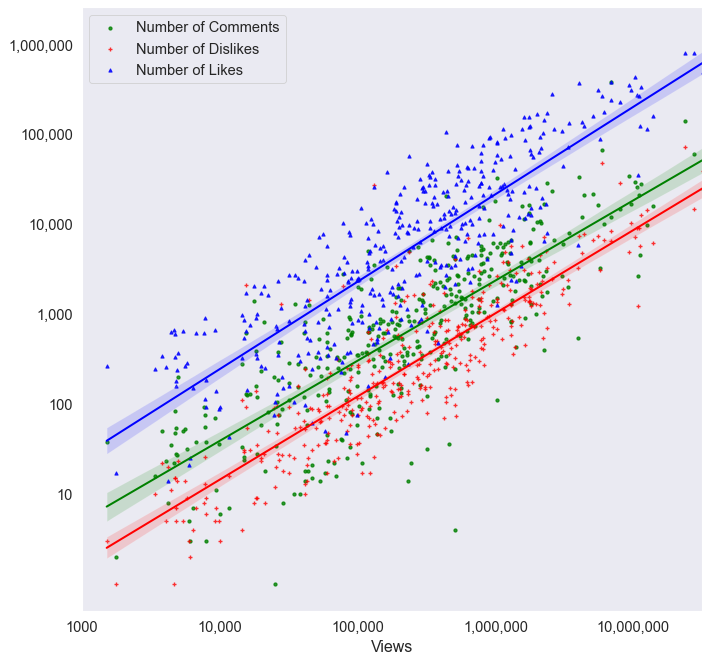

In [115]:
AllDataLDC= AllData[AllData["likes"]>0]
AllDataLDC= AllDataLDC[AllDataLDC["dislikes"]>0]
AllDataLDC= AllDataLDC[AllDataLDC["comment_count"]>0]
AllDataLDC= AllDataLDC[AllDataLDC["views"]>0]

sample = AllDataLDC.sample(n=400, random_state=0)

test = sample[sample["dislikes"]== 0]

sample["logLikes"] = np.log10(sample["likes"])    
sample["logDislikes"] = np.log10(sample["dislikes"])    
sample["logComments"] = np.log10(sample["comment_count"])    
sample["logViews"] = np.log10(sample["views"])    

yLabels = ["Number of likes (Log Scale)"]
markerColors = ['green']
fig,ax = plt.subplots(figsize=(10,10), dpi=80)

test
Comments = sns.regplot(x='logViews',y="logComments",data=sample, color='g',  marker='o', label="Number of Comments",scatter_kws={'s':8} )
Dislikes = sns.regplot(x='logViews',y="logDislikes",data=sample, color='r', marker='+', label="Number of Dislikes", scatter_kws={'s':8})
Likes = sns.regplot(x='logViews',y="logLikes",data=sample,  color='b', marker='^', label="Number of Likes", scatter_kws={'s':8})

ax.set(xlabel="Views", ylabel="",  xticks=[3,4,5,6,7], xticklabels=['1000','10,000', '100,000', '1,000,000', '10,000,000'], xlim=(3,7.5), yticks=[1,2,3,4,5,6], yticklabels=['10', '100', '1,000', '10,000', '100,000', '1,000,000']) 

ax.legend()  

<b>Fig 6. </b><p> We can see that as the number of views increases, the number of dislikes, and likes increase at a similar rate, however it is interesting to note that the comment count seems to increase at a slower rate with views, perhaps there is a lower inclination to comment on videos with more views?</p>

[Text(0.5, 0, 'Views (Millions)'), Text(0, 0.5, 'Dislikes')]

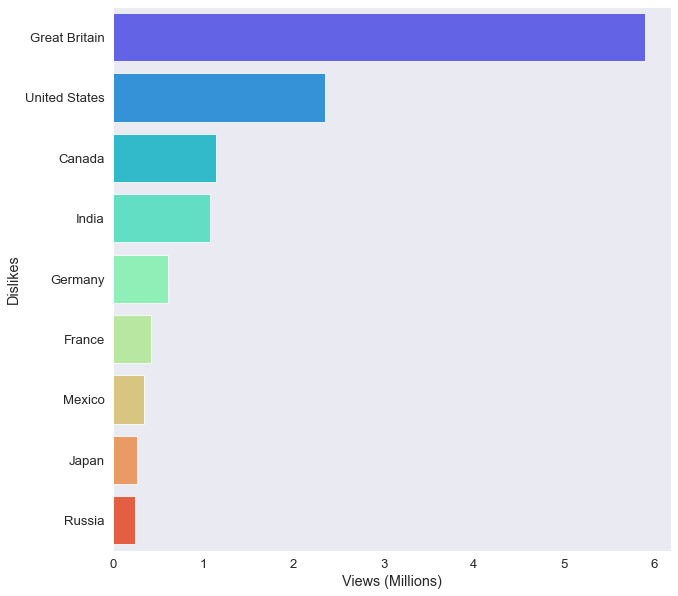

In [146]:
AllDataGrpCntry =   AllData.groupby(['country'])
AllDataGrpDFCntry = AllDataGrpCntry.mean()
AllDataGrpDFCntry["views"] = AllDataGrpDFCntry["views"]/1000000
AllDataGrpDFCntry = AllDataGrpDFCntry.reset_index()

AllDataGrpDFCntry.sort_values(by=['views'], inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10,10))   

sns.barplot(x="views", y="country", data=AllDataGrpDFCntry,palette='rainbow')
ax.set(xlabel="Views (Millions)", ylabel="Dislikes") 


<b>Fig 7. </b><p>Lets have a look at the sentiment of the description field, we will be using a pre-trained sentiment analyser which is used to determine the sentiments of social media posts. The sentiment score is ranked from -1 to +1 to which denotes if a phrase is negative of positive respectiviely - i.e. the phrase "Today was amazing" would rate higher than "Today was quite good". A negative sentament score could be as follows - "Today was a bad day :(". To simplfy things lets just work with the UK dataset</p>

In [68]:
nltk.download(["stopwords", "names"])

stopWords = nltk.corpus.stopwords.words("English")
names = nltk.corpus.names.words()
AllData = AllData[AllData["description"].notnull()]

#remove some very common words which add little information to the sentiment of the description - i.e. company names

extraStopWords = ['ft', 'feat', 'feature', 'video', 'music', 'twitter', 'instagram', 'facebook', 'channel', 'youtube',
                 'show', 'subscribe', 'film', 'website', 'google', 'tumblr', 'album', 'movie']

[stopWords.append(w) for w in extraStopWords]

names = [n.lower() for n in names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JamesStephenson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\JamesStephenson\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [36]:
Uk_Data = AllData.loc[AllData.country == "Great Britain"].copy()

numRecords = Uk_Data["description"].size

def CleanDescription(PhraseToClean):
    CleanWords = [w for w in PhraseToClean.split() if NotUrl(w)]      
    CleanWords = [RemoveNonAlphaNumeric(w) for w in CleanWords]
    CleanWords = [w for w in CleanWords if  NotInStopWords(w) and NotInNames(w)]
    return ' '.join(CleanWords)

def NotInStopWords(word):
    return word.lower() not in stopWords

def NotInNames(word):
    return word.lower() not in names

urlPattern = "http[s]*:\/\/[^ ]*"

def NotUrl(word):
    return not re.match(urlPattern,word)

def RemoveNonAlphaNumeric(phrase):
    return re.sub(r'\W+', '', phrase)

Uk_Data["Cleaned Description"] = Uk_Data["description"].apply(lambda x: CleanDescription(x))

Uk_Data["Cleaned Description"].head()

37970


10049    Eminems new track Walk Water Beyoncé available...
10050     Eds onnFacebook KoenignProducer Honna Kimmere...
10051    Golden Slumbers originally Beatles heard 2017 ...
10052    Lopez Wisin  Amor Amor Amor Official VideonAmo...
10053    Gucci Mane  Curve Weekndnn Mr exclusive Mr mer...
Name: Cleaned Description, dtype: object

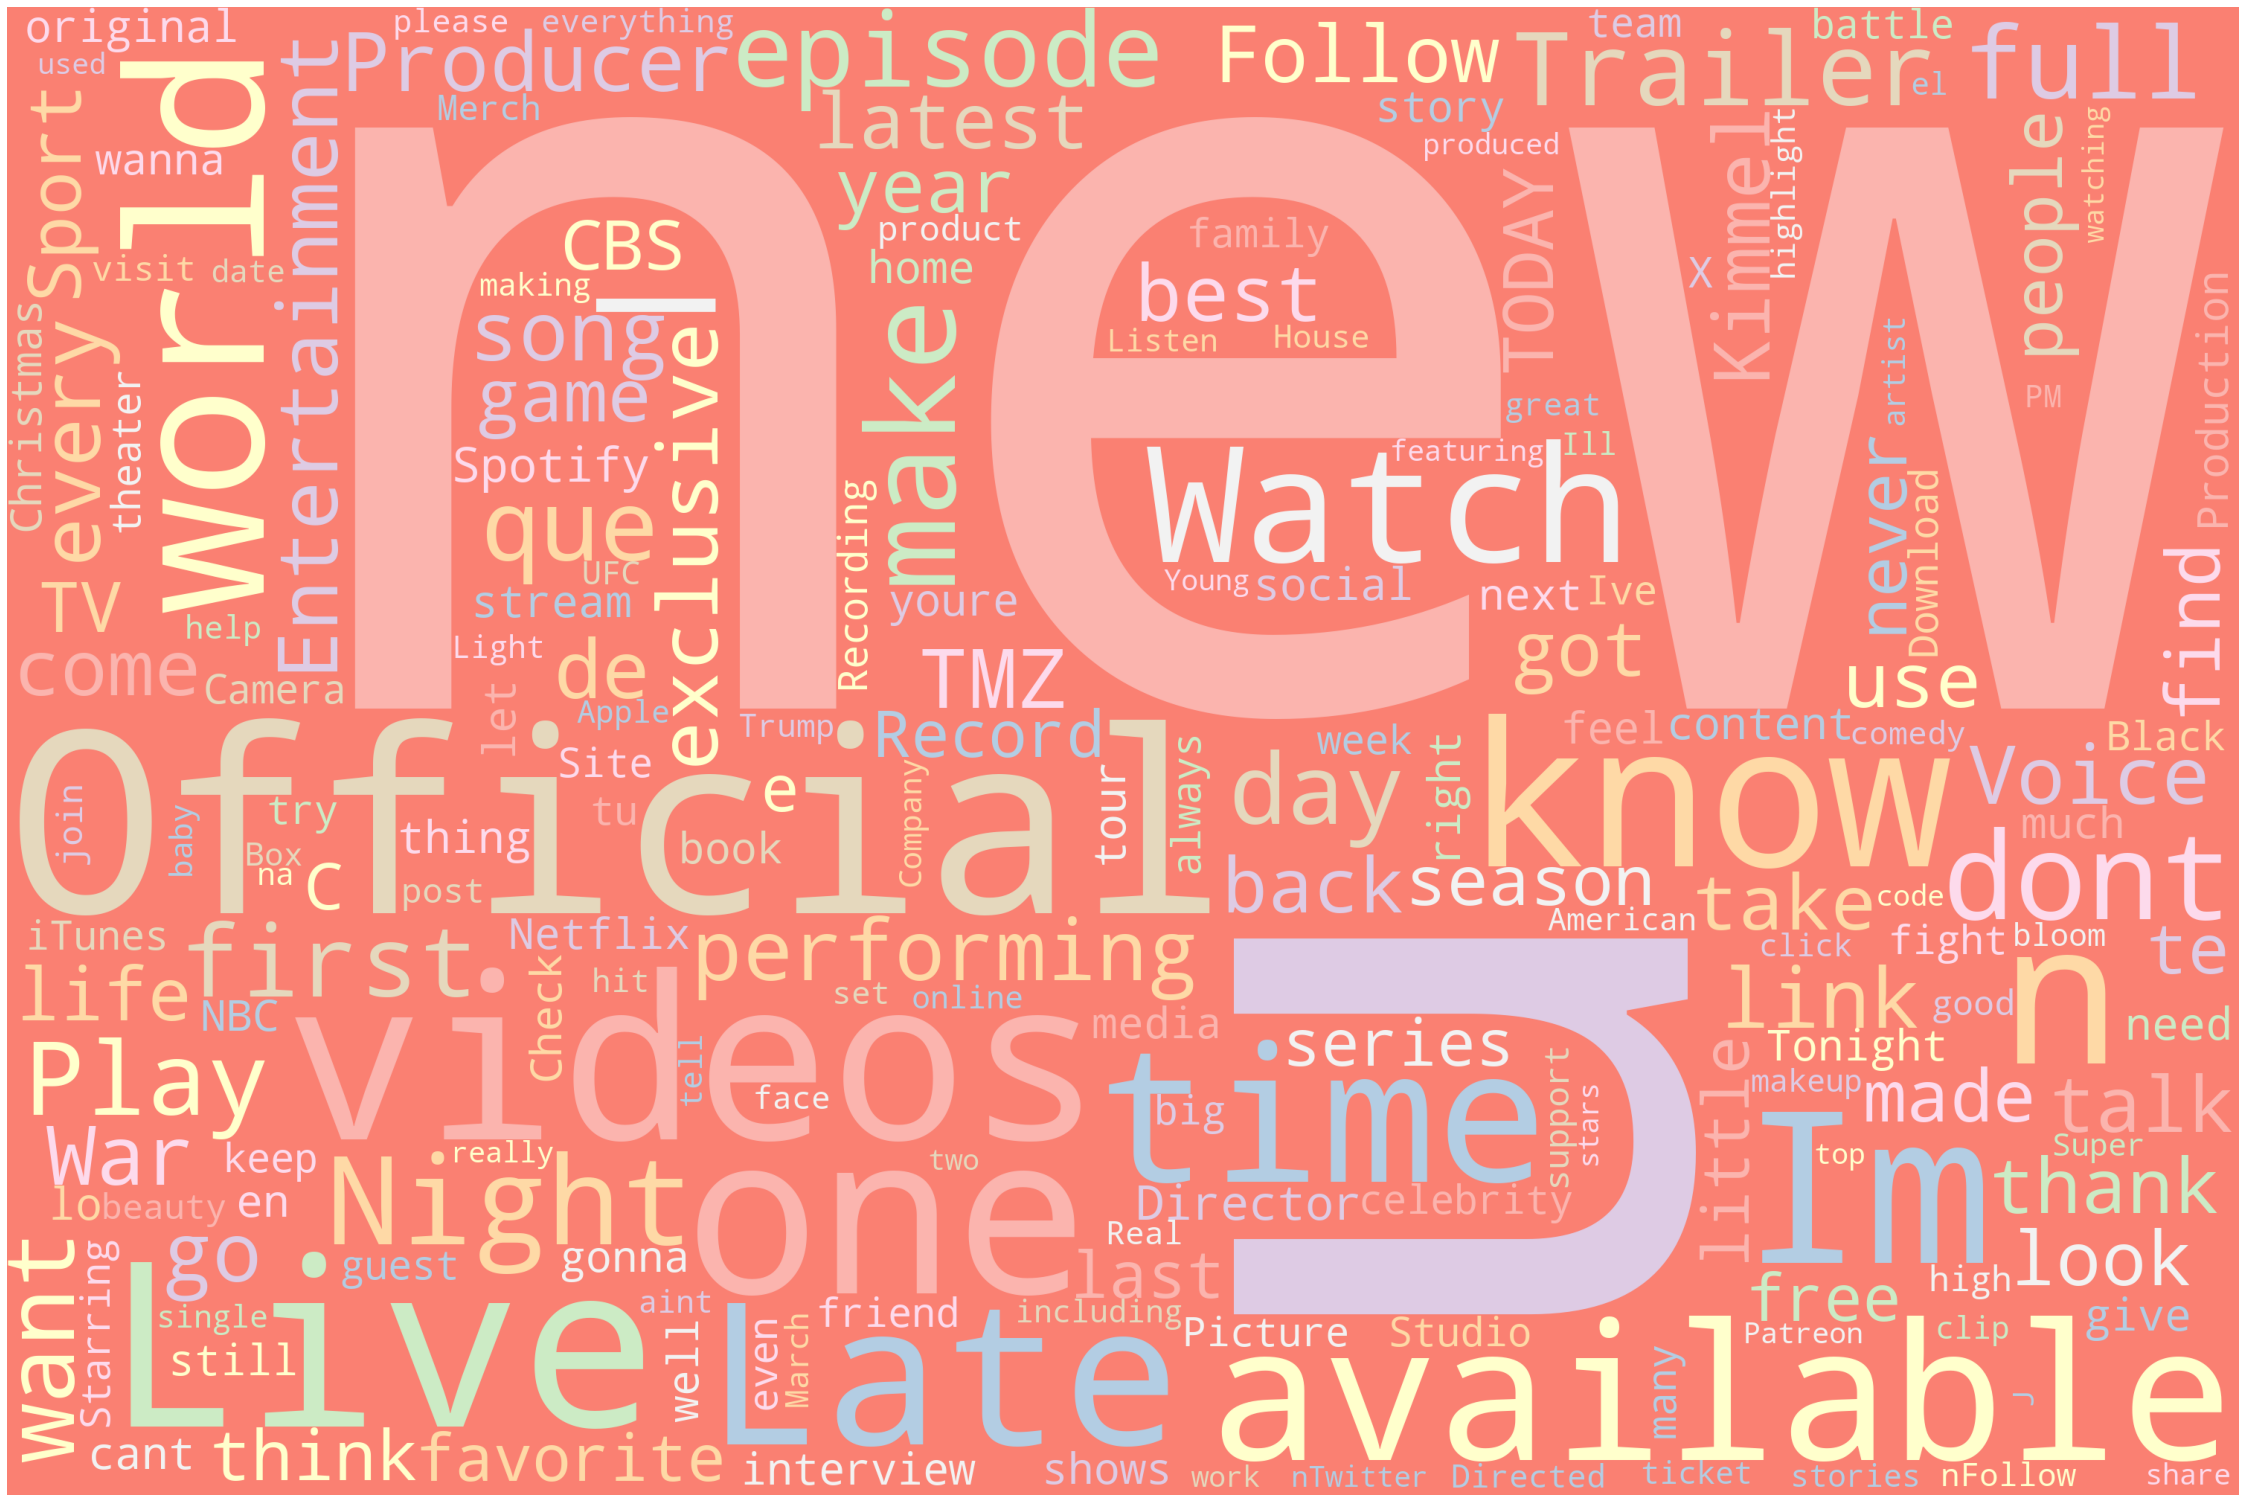

In [37]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(Uk_Data["Cleaned Description"]))

plot_cloud(wordcloud)

<b>Fig 8. </b><p>The above word-cloud shows how certain words are dominant in the video descriptions perhaps unsurpisingly i.e. "New", "Official", "videos". The above methodology was used to determine some of the additional stop words which were added manually for removal. It could be interesting to show a word cloud for different video catagories, but this is being left for further imrpovements</p>

In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JamesStephenson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [70]:
sia = SentimentIntensityAnalyzer()
Uk_Data["Sentiment Scores"] = Uk_Data["Cleaned Description"].apply(lambda x: sia.polarity_scores(x)["compound"])
Uk_Data.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,ratings_disabled,video_error_or_removed,description,country,Catagory Names,Number of Interactions,Like To Dislike Ratio,Views To Interactions Ratio,Cleaned Description,Sentiment Scores
10049,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,...,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Great Britain,Music,956722,0.947740,0.055758,Eminems new track Walk Water Beyoncé available...,0.6369
10050,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634124,21082,...,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,Great Britain,Music,1740273,0.987263,0.051912,Eds onnFacebook KoenignProducer Honna Kimmere...,0.4404
10051,LMCuKltaY3M,17.14.11,Elbow - Golden Slumbers (John Lewis Advert 2017),ElbowVEVO,10,2017-11-10T08:00:01.000Z,"Elbow|""Golden""|""Slumbers""|""Polydor""|""Alternative""",154494,2163,147,...,False,False,"“Golden Slumbers”, originally by The Beatles, ...",Great Britain,Music,2521,0.936364,0.016318,Golden Slumbers originally Beatles heard 2017 ...,0.6369


<P>Now we have the sentiment score let's see if we can identify any interesting trends between the Sentiment Score and other video metrics or if there are any catagories which have distinct Sentiment Scores.</P>

In [71]:
SentimentScores = Uk_Data["Sentiment Scores"]
for col in ['views','likes','dislikes','comment_count','Number of Interactions','Like To Dislike Ratio','Views To Interactions Ratio']:
    print(f"Correlation between Sentiment Score and {col} = { SentimentScores.corr(Uk_Data[col])}")

Correlation between Sentiment Score and views = -0.08935304106230747
Correlation between Sentiment Score and likes = -0.06230473749896081
Correlation between Sentiment Score and dislikes = -0.02644333308057936
Correlation between Sentiment Score and comment_count = -0.027170432220374734
Correlation between Sentiment Score and Number of Interactions = -0.05890651370853729
Correlation between Sentiment Score and Like To Dislike Ratio = 0.02320181562248019
Correlation between Sentiment Score and Views To Interactions Ratio = 0.023071696262660618


<p>There are no significant correlation between the Sentiment score of the description and any particular video metrics, lastly lets look at whether the sentiment score vary between video catagories.</p>

<AxesSubplot:xlabel='Sentiment Scores', ylabel='Catagory Names'>

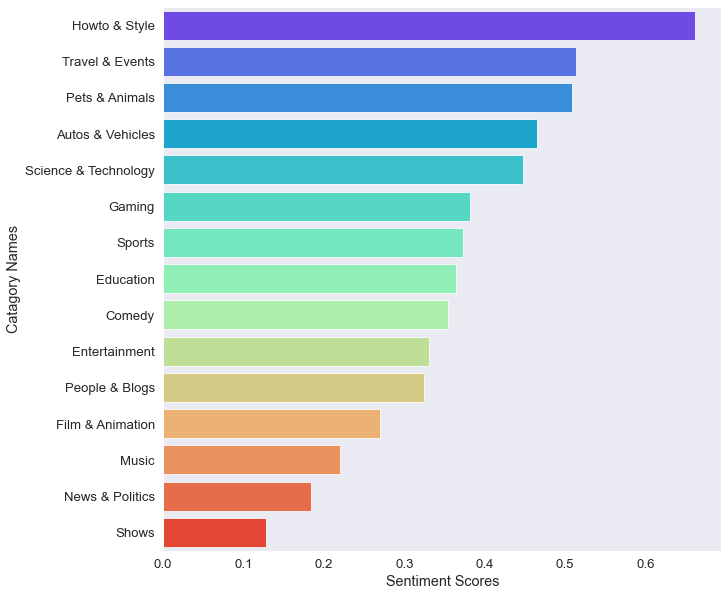

In [72]:
Uk_DataGrp =  Uk_Data.groupby(['Catagory Names'])
Uk_DataGrpDF = Uk_DataGrp.mean()
Uk_DataGrpDF.sort_values(by=['Sentiment Scores'], inplace=True, ascending=False)

Uk_DataGrpDF = Uk_DataGrpDF.reset_index()
fig, ax = plt.subplots(figsize=(10,10))   
sns.barplot(x="Sentiment Scores", y="Catagory Names", data=Uk_DataGrpDF,palette='rainbow')

<b>Fig 9. </b>

<p> Descriptions of videos of certain catagories are perhaps unsurprisingly more positive than others, for instance it is intuitive to see why Travel Videos, which often are used to depict a glamourous view of a tourist location would have a more positive description than News and Politics which often describe an story in an unfavourable way dependending on the poltical affiliation of the channel and their respective values allign with the story they are describing.  It is interesting to note that the trends of catagories in Fig 9 and Fig 5 match well - under the assumption both Fig 5 and Fig 9 map to how "controversial" a video viewership and description is respectively, it is interesting to note that a majority of the most and least controversial video catagories corroborate approximately between Figures. I.e. "News and Politics" is the most and second most controversial catagory according to Fig 5 and 9 respectively, as "Pets and Animals" is the Least and Third Least. 

Below are the catagories in order of controversy according to Fig 5 and 9 to desmonstrate the similarity between these two Datasets more visually.
</p>

In [187]:
cats = AllDataGrpDF["Catagory Names"].tolist()
catsDF = pd.DataFrame()
for cat in cats:
    tmpDF = pd.DataFrame([[cat, 
                          str(len(AllDataGrpDF.index) - AllDataGrpDF.index[AllDataGrpDF["Catagory Names"] == cat].tolist()[0]),
                          (1+ Uk_DataGrpDF.index[Uk_DataGrpDF["Catagory Names"] == cat].tolist()[0])]],
                         columns=["Catagory", "Figure 5 Rank", "Figure 9 Rank"]
                        )
    catsDF = catsDF.append(tmpDF)
    
catsDF.set_index("Catagory", inplace=True)   
catsDF

,Figure 5 Rank,Figure 9 Rank
Catagory,,
News & Politics,15,14
Shows,14,15
Entertainment,13,10
People & Blogs,12,11
Gaming,11,6
Sports,10,7
Autos & Vehicles,9,4
Travel & Events,8,2
Science & Technology,7,5


<b>Fig 10.</b>
<p>Figure showing the rank of each catagory in the orderered column lists in Fiures 5 and 9 respectively. The ranking order of figure 5 represents the like to dislike ratio in descending order and the sentiment of the video description of figure 9. Below is a line plot which shows how these two rankings relate to each other.</p>

<AxesSubplot:xlabel='Figure 5 Rank', ylabel='Figure 9 Rank'>

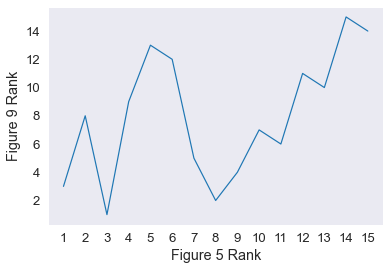

In [194]:
sns.lineplot(data=catsDF.reindex(index=catsDF.index[::-1]), x="Figure 5 Rank", y="Figure 9 Rank")
